<a href="https://colab.research.google.com/github/okayteakay/Numerical-Hand-Signs-Recognition/blob/main/Numeric_Hand_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT LIBRARIES

In [1]:
# pip install -q (quiet)
!pip install git+https://github.com/keras-team/keras-tuner.git -q


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import kerastuner
import IPython
import h5py
import sklearn
import time
import datetime
import pytz
from mlxtend.plotting import plot_decision_regions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from sklearn import datasets 
from sklearn.metrics import confusion_matrix
from kerastuner.tuners import RandomSearch

In [3]:
print(tf.__version__)

2.4.1


In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### LOAD AND PREPROCESS DATA

In [5]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    df1 = np.array(train_dataset["train_set_x"][:]) # your train set features
    df2 = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    df3 = np.array(test_dataset["test_set_x"][:]) # your test set features
    df4 = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    df2 = df2.reshape((1, df2.shape[0]))
    df4 = df4.reshape((1, df4.shape[0]))
    
    return df1, df2, df3, df4, classes

In [6]:
df1, df2, df3, df4, classes = load_dataset()

In [7]:
df4.shape

(1, 120)

label =  3


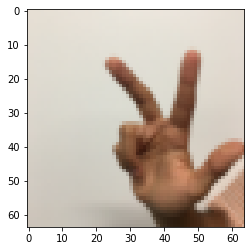

In [8]:
plt.imshow(df1[23])
print('label = ',str(np.squeeze(df2[:, 23])))

In [9]:
df1[23].shape

(64, 64, 3)

In [10]:
#Normalizing the training and test images
X_train_n = df1/255.
X_test_n = df3/255.
# Flatten the training and test images
X_train_f = X_train_n.reshape(X_train_n.shape[0], -1)
X_test = X_test_n.reshape(X_test_n.shape[0], -1)
# Convert training and test labels to one hot matrices
y_train_oh = tf.keras.utils.to_categorical(df2).squeeze()
y_test = tf.keras.utils.to_categorical(df4).squeeze()

print ("number of training examples = " + str(X_train_f.shape[0]))
print ("number of test examples = " + str(  X_test.shape[0]))
print ("X_train shape: " + str(X_train_f.shape))
print ("Y_train shape: " + str(y_train_oh.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 12288)
Y_train shape: (1080, 6)
X_test shape: (120, 12288)
Y_test shape: (120, 6)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train_f, y_train_oh, test_size=0.25, random_state=114)

In [12]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
X_val = np.asarray(X_val).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)


### DEFINE FUNCTIONS

In [17]:
def print_analysis(titles,history):
  loss = ["loss", "val_loss"]
  accuracy = ["categorical_accuracy","val_categorical_accuracy"]
  f, axs = plt.subplots(1,2,figsize=(10,4))
  
  for i,item in enumerate([loss,accuracy]):
    axs[i].plot(history.history[item[0]])
    axs[i].plot(history.history[item[1]])
    axs[i].set_ylabel(item[0])
    axs[i].set_xlabel('epoch')
    axs[i].legend(['train', 'val'], loc='best')
    if i == 1:
      axs[i].set_ylim(0,1)

  f.suptitle(titles, y=1.1)
  plt.tight_layout()
  plt.show()

In [59]:
def print_scores(model):
  loss, accuracy = model.evaluate(X_test, y_test,batch_size=32)
  print('Test loss in model:', loss)
  print('Test accuracy in model:', accuracy)


In [25]:
def print_confusion_matrix(model):
  y_pred = model.predict(X_test)
  y_pred = (y_pred > 0.5)
  a = np.argmax(y_pred, axis=1)
  a = a.reshape(-1,1)
  y_true = df4
  y_true = y_true.reshape(-1,1)
  cm = confusion_matrix(y_true, a)
  print(cm)

## MODELS



#### MODEL 1 - DEEP CLASSIFIFICATION

In [18]:
tf.random.set_seed(3)

# Instantiate a simple classification model
model1 = tf.keras.Sequential([tf.keras.layers.Dense(256, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(128, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(64, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(64, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(32, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(16, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(6, activation = tf.nn.softmax,kernel_initializer="he_uniform")
                             ])

In [19]:
model1.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['categorical_accuracy'])

In [20]:
hist1 = model1.fit(X_train,y_train, epochs=500, batch_size = 32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/500
26/26 [==============================] - 2s 38ms/step - loss: 3.4428 - categorical_accuracy: 0.1945 - val_loss: 1.9991 - val_categorical_accuracy: 0.1704
Epoch 2/500
26/26 [==============================] - 1s 31ms/step - loss: 1.8521 - categorical_accuracy: 0.1760 - val_loss: 1.8340 - val_categorical_accuracy: 0.1704
Epoch 3/500
26/26 [==============================] - 1s 30ms/step - loss: 1.8529 - categorical_accuracy: 0.1515 - val_loss: 1.8185 - val_categorical_accuracy: 0.1963
Epoch 4/500
26/26 [==============================] - 1s 31ms/step - loss: 1.8203 - categorical_accuracy: 0.1972 - val_loss: 1.7636 - val_categorical_accuracy: 0.2259
Epoch 5/500
26/26 [==============================] - 1s 30ms/step - loss: 1.7593 - categorical_accuracy: 0.2115 - val_loss: 1.7539 - val_categorical_accuracy: 0.2148
Epoch 6/500
26/26 [==============================] - 1s 31ms/step - loss: 1.7517 - categorical_accuracy: 0.2279 - val_loss: 1.8689 - val_categorical_accuracy: 0.1741
Epoc

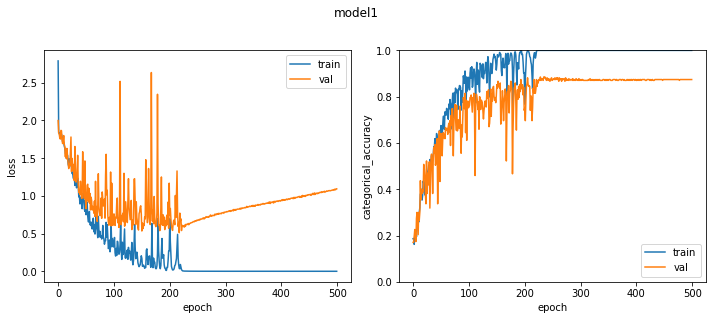

In [21]:
print_analysis('model1', hist1)

In [60]:
print_scores(model1)

4/4 [==============================] - 0s 8ms/step - loss: 1.0260 - categorical_accuracy: 0.8583
Test loss in model: 1.026004672050476
Test accuracy in model: 0.8583333492279053


In [26]:
print_confusion_matrix(model1)

[[20  0  0  0  0  0]
 [ 0 19  0  0  0  1]
 [ 0  2 16  0  2  0]
 [ 0  0  0 16  3  1]
 [ 0  0  0  3 15  2]
 [ 0  0  0  1  2 17]]


In [65]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               3145984   
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 6)                

#### MODEL 2 - SIMPLE CLASSIFICATION

In [53]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model2 = tf.keras.Sequential([
                             tf.keras.layers.Dense(25, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform"),
                             tf.keras.layers.Dense(6, activation = tf.nn.softmax,kernel_initializer="he_uniform")
                             ])

# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# configure the optimizer, loss, and metrics to monitor.
model2.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

In [54]:
hist2 = model2.fit(X_train,y_train, epochs=500, batch_size = 32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/500
26/26 [==============================] - 1s 14ms/step - loss: 1.9146 - categorical_accuracy: 0.1757 - val_loss: 1.8263 - val_categorical_accuracy: 0.1481
Epoch 2/500
26/26 [==============================] - 0s 8ms/step - loss: 1.8034 - categorical_accuracy: 0.1501 - val_loss: 1.7864 - val_categorical_accuracy: 0.1926
Epoch 3/500
26/26 [==============================] - 0s 8ms/step - loss: 1.7983 - categorical_accuracy: 0.1771 - val_loss: 1.8228 - val_categorical_accuracy: 0.1630
Epoch 4/500
26/26 [==============================] - 0s 8ms/step - loss: 1.7881 - categorical_accuracy: 0.2097 - val_loss: 1.7836 - val_categorical_accuracy: 0.2185
Epoch 5/500
26/26 [==============================] - 0s 8ms/step - loss: 1.7647 - categorical_accuracy: 0.2033 - val_loss: 1.7946 - val_categorical_accuracy: 0.1815
Epoch 6/500
26/26 [==============================] - 0s 8ms/step - loss: 1.7783 - categorical_accuracy: 0.2194 - val_loss: 1.7614 - val_categorical_accuracy: 0.2556
Epoch 7/5

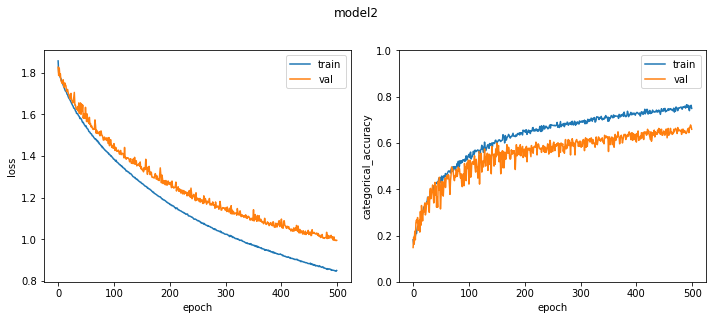

In [55]:
print_analysis('model2', hist2)

In [62]:
print_scores(model2)

4/4 [==============================] - 0s 4ms/step - loss: 0.9544 - categorical_accuracy: 0.7083
Test loss in model: 0.9544059634208679
Test accuracy in model: 0.7083333134651184


In [61]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 25)                307225    
_________________________________________________________________
dense_18 (Dense)             (None, 12)                312       
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 78        
Total params: 307,615
Trainable params: 307,615
Non-trainable params: 0
_________________________________________________________________


#### MODEL 3 - HYPERPARAMETER TUNING

In [78]:
def hp_model(hp):
  # Instantiate a simple classification model
  model3 = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 20-40 with step 5
  hp_units = hp.Int('units', min_value = 20, max_value = 60, step = 3)
  model3.add(tf.keras.layers.Dense(hp_units, activation=tf.nn.relu,kernel_initializer="he_uniform"))

  model3.add(tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform"))
  model3.add(tf.keras.layers.Dense(6, activation=tf.nn.softmax,kernel_initializer="he_uniform"))
  

  # configure the optimizer, loss, and metrics to monitor.
  model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Float('lrate_sgd',min_value=1e-4,max_value=1e-2,sampling='LOG')), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()]) 

  return model3

In [79]:
# path to store results
LOG_DIR = f"{int(time.time())}"

In [80]:
tuner = RandomSearch(hp_model,
                     objective='categorical_accuracy',
                     max_trials=9,  # how many model configurations would you like to test?
                     executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
                     directory=LOG_DIR,
                     project_name="500_epochs"
                     )

In [81]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [82]:
tuner.search(X_train,
             y_train, 
             epochs = 500, 
             verbose=1,
             batch_size=32,
             validation_data = (X_val,y_val),
             callbacks = [ClearTrainingOutput()])

Trial 9 Complete [00h 02m 02s]
categorical_accuracy: 0.9740740656852722

Best categorical_accuracy So Far: 0.9753086566925049
Total elapsed time: 00h 20m 11s
INFO:tensorflow:Oracle triggered exit


In [83]:
# print a summary of results
tuner.results_summary(num_trials=3)

Results summary
Results in 1613752739/500_epochs
Showing 3 best trials
Objective(name='categorical_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 47
lrate_sgd: 0.0019995992408133965
Score: 0.9753086566925049
Trial summary
Hyperparameters:
units: 26
lrate_sgd: 0.0009900158563390824
Score: 0.9740740656852722
Trial summary
Hyperparameters:
units: 53
lrate_sgd: 0.00048429650645626137
Score: 0.9654321074485779


In [84]:
tuner.get_best_hyperparameters()[0].values


{'lrate_sgd': 0.0019995992408133965, 'units': 47}

In [85]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 60, 'step': 3, 'sampling': None}
lrate_sgd (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [86]:
print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {tuner.get_best_hyperparameters()[0].values.get('units')}""")

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 47


In [87]:
best_hps = tuner.get_best_hyperparameters()[0]
model3 = tuner.hypermodel.build(best_hps)
hist3 = model3.fit(X_train, y_train, epochs = 500, validation_data = (X_test, y_test),batch_size=32)

Epoch 1/500
26/26 [==============================] - 1s 16ms/step - loss: 1.8217 - categorical_accuracy: 0.1773 - val_loss: 1.7993 - val_categorical_accuracy: 0.1667
Epoch 2/500
26/26 [==============================] - 0s 8ms/step - loss: 1.7856 - categorical_accuracy: 0.1929 - val_loss: 1.7919 - val_categorical_accuracy: 0.1833
Epoch 3/500
26/26 [==============================] - 0s 9ms/step - loss: 1.7897 - categorical_accuracy: 0.1535 - val_loss: 1.7922 - val_categorical_accuracy: 0.1667
Epoch 4/500
26/26 [==============================] - 0s 9ms/step - loss: 1.7886 - categorical_accuracy: 0.1888 - val_loss: 1.7831 - val_categorical_accuracy: 0.1750
Epoch 5/500
26/26 [==============================] - 0s 9ms/step - loss: 1.7879 - categorical_accuracy: 0.1620 - val_loss: 1.7838 - val_categorical_accuracy: 0.1667
Epoch 6/500
26/26 [==============================] - 0s 11ms/step - loss: 1.7879 - categorical_accuracy: 0.1736 - val_loss: 1.8502 - val_categorical_accuracy: 0.1667
Epoch 7/

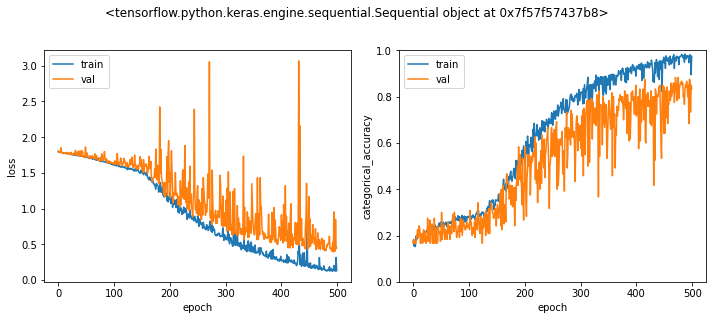

In [91]:
print_analysis(model3, hist3)

In [92]:
print_scores(model3)

4/4 [==============================] - 0s 4ms/step - loss: 0.4503 - categorical_accuracy: 0.8333
Test loss in model: 0.4502978026866913
Test accuracy in model: 0.8333333134651184


In [101]:
print_confusion_matrix(model3)

[[20  0  0  0  0  0]
 [ 0 19  0  1  0  0]
 [ 2  2 14  1  1  0]
 [ 3  0  0 17  0  0]
 [ 2  0  0  2 14  2]
 [ 1  0  0  1  2 16]]


In [93]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 47)                577583    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
Total params: 578,237
Trainable params: 578,237
Non-trainable params: 0
_________________________________________________________________


#### MODEL 4 - BATCH NORMALIZATION

In [94]:
# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)

# Instantiate a simple classification model
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Dense(47, kernel_initializer="he_uniform"))
model4.add(tf.keras.layers.BatchNormalization())
model4.add(tf.keras.layers.Activation(tf.nn.relu))

model4.add(tf.keras.layers.Dense(12,kernel_initializer="he_uniform"))
model4.add(tf.keras.layers.BatchNormalization())
model4.add(tf.keras.layers.Activation(tf.nn.relu))

model4.add(tf.keras.layers.Dense(6, activation=tf.nn.softmax,kernel_initializer="he_uniform"))



In [95]:
model4.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate=0.001), metrics = ['categorical_accuracy'])

In [96]:
hist4 = model4.fit(X_train,y_train, epochs=500, batch_size = 32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/500
26/26 [==============================] - 1s 17ms/step - loss: 1.9041 - categorical_accuracy: 0.2649 - val_loss: 2.4491 - val_categorical_accuracy: 0.1704
Epoch 2/500
26/26 [==============================] - 0s 9ms/step - loss: 1.4062 - categorical_accuracy: 0.4667 - val_loss: 2.6394 - val_categorical_accuracy: 0.1704
Epoch 3/500
26/26 [==============================] - 0s 9ms/step - loss: 1.2279 - categorical_accuracy: 0.5436 - val_loss: 2.5525 - val_categorical_accuracy: 0.1704
Epoch 4/500
26/26 [==============================] - 0s 10ms/step - loss: 1.1381 - categorical_accuracy: 0.6035 - val_loss: 2.4450 - val_categorical_accuracy: 0.1741
Epoch 5/500
26/26 [==============================] - 0s 10ms/step - loss: 1.0467 - categorical_accuracy: 0.6746 - val_loss: 2.2100 - val_categorical_accuracy: 0.1889
Epoch 6/500
26/26 [==============================] - 0s 10ms/step - loss: 0.9683 - categorical_accuracy: 0.7221 - val_loss: 1.8493 - val_categorical_accuracy: 0.2556
Epoch 

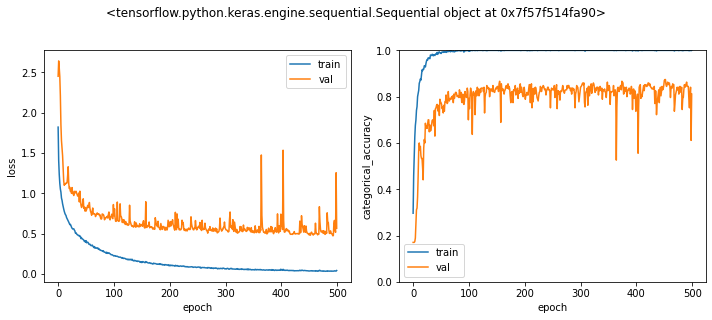

In [98]:
print_analysis(model4, hist4)

In [99]:
print_scores(model4)

4/4 [==============================] - 0s 4ms/step - loss: 0.4718 - categorical_accuracy: 0.8417
Test loss in model: 0.47184523940086365
Test accuracy in model: 0.8416666388511658


In [100]:
print_confusion_matrix(model4)

[[20  0  0  0  0  0]
 [ 3 16  0  0  1  0]
 [ 3  1 16  0  0  0]
 [ 4  0  0 14  1  1]
 [ 3  0  1  0 16  0]
 [ 1  0  0  1  3 15]]


In [102]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 47)                577583    
_________________________________________________________________
batch_normalization (BatchNo (None, 47)                188       
_________________________________________________________________
activation (Activation)      (None, 47)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                576       
_________________________________________________________________
batch_normalization_1 (Batch (None, 12)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

#### MODEL 5 - REGULARIZATION

In [103]:
def model_regularize(hp):
  # Instantiate a simple classification model
  model5 = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 20-40 with step 5
  hp1 = hp.Float('units', min_value = 0.008, max_value = 0.2, sampling = 'LOG')
  hp2 = hp.Float('units', min_value = 0.008, max_value = 0.2, sampling = 'LOG')

  model5.add(tf.keras.layers.Dense(47, activation=tf.nn.relu,kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(l=hp1)))
  model5.add(tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(l=hp2)))
  model5.add(tf.keras.layers.Dense(6, activation=tf.nn.softmax,kernel_initializer="he_uniform"))

  # configure the optimizer, loss, and metrics to monitor.
  model5.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate=0.001132), metrics = ['categorical_accuracy'])

  return model5


In [105]:
tuner = RandomSearch(model_regularize,
                     objective='val_categorical_accuracy',
                     max_trials=9,  # how many model configurations would you like to test?
                     executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
                     project_name="regularization"
                     )

In [106]:
tuner.search(X_train,
             y_train, 
             epochs = 500, 
             verbose=1,
             batch_size=32,
             validation_data = (X_test,y_test),
             callbacks = [ClearTrainingOutput()])

Trial 9 Complete [00h 02m 35s]
val_categorical_accuracy: 0.7916666865348816

Best val_categorical_accuracy So Far: 0.8500000238418579
Total elapsed time: 00h 23m 02s
INFO:tensorflow:Oracle triggered exit


In [107]:
tuner.results_summary(num_trials=3)

Results summary
Results in ./regularization
Showing 3 best trials
Objective(name='val_categorical_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 0.0306769948051179
Score: 0.8500000238418579
Trial summary
Hyperparameters:
units: 0.05093844895946503
Score: 0.8500000238418579
Trial summary
Hyperparameters:
units: 0.013077772328809406
Score: 0.8083333373069763


In [108]:
tf.random.set_seed(3)

# Instantiate a simple classification model
model5 = tf.keras.Sequential([
                             tf.keras.layers.Dense(35, activation=tf.nn.relu,kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(l=0.03827615637390504)),
                             tf.keras.layers.Dense(12, activation=tf.nn.relu,kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(l=0.008945203543008127)),
                             tf.keras.layers.Dense(6, activation = tf.nn.softmax,kernel_initializer="he_uniform")
                             ])


In [111]:
model5.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate=0.001132), metrics = ['categorical_accuracy'])


In [112]:
hist5 = model5.fit(X_train,y_train, epochs=500, batch_size = 32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/500
26/26 [==============================] - 1s 16ms/step - loss: 4.7616 - categorical_accuracy: 0.1562 - val_loss: 4.6610 - val_categorical_accuracy: 0.1852
Epoch 2/500
26/26 [==============================] - 0s 10ms/step - loss: 4.6577 - categorical_accuracy: 0.2391 - val_loss: 4.6528 - val_categorical_accuracy: 0.1407
Epoch 3/500
26/26 [==============================] - 0s 10ms/step - loss: 4.6570 - categorical_accuracy: 0.1776 - val_loss: 4.6398 - val_categorical_accuracy: 0.1407
Epoch 4/500
26/26 [==============================] - 0s 10ms/step - loss: 4.6369 - categorical_accuracy: 0.1800 - val_loss: 4.6264 - val_categorical_accuracy: 0.1370
Epoch 5/500
26/26 [==============================] - 0s 10ms/step - loss: 4.6163 - categorical_accuracy: 0.1689 - val_loss: 4.6179 - val_categorical_accuracy: 0.1556
Epoch 6/500
26/26 [==============================] - 0s 10ms/step - loss: 4.6139 - categorical_accuracy: 0.1509 - val_loss: 4.6023 - val_categorical_accuracy: 0.1667
Epoc

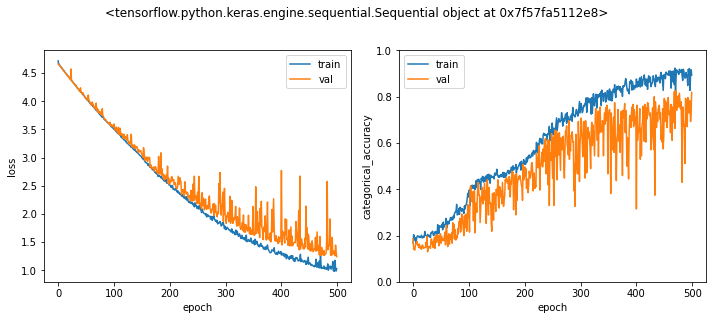

In [113]:
print_analysis(model5, hist5)

In [116]:
print_scores(model5)

4/4 [==============================] - 0s 4ms/step - loss: 1.1944 - categorical_accuracy: 0.8083
Test loss in model: 1.1944094896316528
Test accuracy in model: 0.8083333373069763


In [117]:
print_confusion_matrix(model5)

[[20  0  0  0  0  0]
 [ 0 19  1  0  0  0]
 [ 3  2 14  0  1  0]
 [ 8  0  0 11  0  1]
 [ 8  0  0  3  8  1]
 [ 8  0  0  0  0 12]]


In [118]:
model5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 35)                430115    
_________________________________________________________________
dense_4 (Dense)              (None, 12)                432       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 78        
Total params: 430,625
Trainable params: 430,625
Non-trainable params: 0
_________________________________________________________________


#### MODEL 6 - CNN

In [124]:
model6 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (5,5), activation=tf.nn.relu, input_shape=(64,64,3)),
  tf.keras.layers.MaxPool2D((3,3)),
  tf.keras.layers.Conv2D(32, (5,5), activation=tf.nn.relu),
  tf.keras.layers.MaxPool2D((3,3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                51264     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

In [125]:
model6.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['categorical_accuracy'])


In [126]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('X_val:', X_val.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('y_val:', y_val.shape)
print('df1:', df1.shape)
print('df2:', df2.shape)
print('df3:', df3.shape)
print('df4:', df4.shape)

X_train: (810, 12288)
X_test: (120, 12288)
X_val: (270, 12288)
y_train: (810, 6)
y_test: (120, 6)
y_val: (270, 6)
df1: (1080, 64, 64, 3)
df2: (1, 1080)
df3: (120, 64, 64, 3)
df4: (1, 120)


In [131]:
hist6 = model6.fit(X_train_n,y_train_oh, epochs=100, batch_size = 32, validation_data=(X_test_n,y_test), verbose=1)

Epoch 1/100
34/34 [==============================] - 4s 103ms/step - loss: 1.0616 - categorical_accuracy: 0.6176 - val_loss: 1.0032 - val_categorical_accuracy: 0.6417
Epoch 2/100
34/34 [==============================] - 4s 105ms/step - loss: 0.8588 - categorical_accuracy: 0.6889 - val_loss: 0.9217 - val_categorical_accuracy: 0.6333
Epoch 3/100
34/34 [==============================] - 4s 105ms/step - loss: 0.7717 - categorical_accuracy: 0.7324 - val_loss: 0.7264 - val_categorical_accuracy: 0.7333
Epoch 4/100
34/34 [==============================] - 3s 100ms/step - loss: 0.5961 - categorical_accuracy: 0.8111 - val_loss: 0.5893 - val_categorical_accuracy: 0.8083
Epoch 5/100
34/34 [==============================] - 3s 102ms/step - loss: 0.5029 - categorical_accuracy: 0.8352 - val_loss: 0.5169 - val_categorical_accuracy: 0.8417
Epoch 6/100
34/34 [==============================] - 3s 99ms/step - loss: 0.4375 - categorical_accuracy: 0.8556 - val_loss: 0.4662 - val_categorical_accuracy: 0.8333

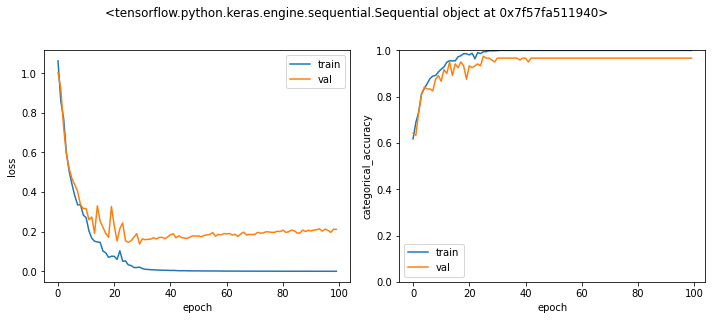

In [132]:
print_analysis(model6, hist6)

In [136]:
loss, acc = model6.evaluate(x=X_train_n,y=y_train_oh, batch_size=32)
print('Train loss: %.3f - acc: %.3f' % (loss, acc))

loss_, acc_ = model6.evaluate(x=X_test_n,y=y_test, batch_size=32)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

34/34 [==============================] - 1s 30ms/step - loss: 3.2100e-04 - categorical_accuracy: 1.0000
Train loss: 0.000 - acc: 1.000
4/4 [==============================] - 0s 28ms/step - loss: 0.2116 - categorical_accuracy: 0.9667
Test loss: 0.212 - acc: 0.967


# USER TESTING

float32
(1, 64, 64, 3)


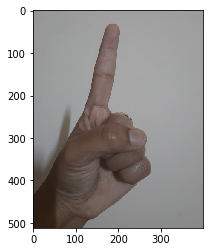

In [137]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from skimage.transform import resize

# load the image
img1 = load_img('one.jpg')

# convert to numpy array
img_array = img_to_array(img1)/255
img_array_res = resize(img_array, (64,64)).reshape((1, 64,64,3))

print(img_array_res.dtype)
print(img_array_res.shape)

plt.imshow(img_array)

In [138]:
model6.predict(img_array_res).argmax()


1

float32
(1, 64, 64, 3)


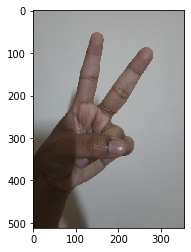

In [140]:
img2 = load_img('two.jpg')
img_array = img_to_array(img2)/255
img_array_res = resize(img_array, (64,64)).reshape((1, 64,64,3))
print(img_array_res.dtype)
print(img_array_res.shape)
plt.imshow(img_array)


In [141]:
model6.predict(img_array_res).argmax()

2